In [1]:
import scipy
import numpy as np
import pandas as pd
import itertools as it
import time

import collections

def recursively_default_dict():
        return collections.defaultdict(recursively_default_dict)

from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import MeanShift, estimate_bandwidth

from scipy.stats import invgamma 
from scipy.stats import beta

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.figure_factory as ff

from IPython.display import clear_output

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
init_notebook_mode(connected=True)


### targeted AMOVA

A script is provided to estimate and store the among group component of AMOVA 
across genomic sites. The script takes genotype data stored in format `.geno`.
Genotye file is positional and provided without flag. No limit is set on number of 
genotype files but must be labelled for chromosome as such: `chr` followed by number.


**Other input files required:**

- **.bim** and **.fam** files (plink format) indicated by flags `--bim` and `--fam` respectively.

- **ref** and **admx** (optional) files: two column file {code; ID} positional, no headers. Labels in ref file used for 
AMOVA calculations if `--supervised` is passed.

- **Coordinates** file (optional): passed using `--aims` argument. Required columns: {ID; start; end; CHR}


**Other features**
- `--mrg`: integer. Extends windows used by number of base pairs provided (devpd for known coordinates). 
- `--randN`: integer. Number of random windows to survey across chromosomes provided. 
- `--w`: integer. Size of random windows to extract. In Snp number.
- `--amova`: No value. Calculate and store amova across windows surveyed.


**Example command**

`
qsub -N amovaEasy -V -q normal.q -l mem_free=30G -b y python -u AMOVA_PCA.py \
/gs7k1/home/jgarcia/olde_home/FILTER_GENO/SplitGENO/GENO_chr08.geno \
--fam /gs7k1/home/jgarcia/olde_home/FILTER_GENO/F3G/NG_001.fam \
--bim /gs7k1/home/jgarcia/olde_home/FILTER_GENO/F3G/NG_001.bim \
--ref /gs7k1/home/jgarcia/PO_Core/refs_CORE.txt \
--admx /gs7k1/home/jgarcia/PO_Core/admx_CORE.txt \
--amova \
--supervised \
-w 150 \
--dr PCA \
--random \
-w 150 \
--randN 20 \
--id AMOVA_gitexample \
--out AMOVA_gitexample
`



## AMOVA for genomic analysis.

Analysis of Molecular Variance (AMOVA) is a statistical method for estimating the degree of molecular divergence between populations. It was first introduced by Excoffier *et al.* (1992) for the study of human haplotype variation. AMOVA is a particularly versatile method because it is not restrained by an assumption of normality and can thus accomodate different evolutionary scenarios. 

The secret to this versatility is that AMOVA deals directly with the matrix of pairwise differences between observations. In other words, the complicated business of adjusting indivdual distances to a particular model is relegated to the construction of the matrix. With this first step concluded, the aim of the analysis is to find out and describe that hierarchical structure splitting the total variance of the matrix into covariance components due to intra-populations, inter-populations and inter-groups differences (Excoffier, 2000). 

In this notebook we tackle the problem of the construction of the differences matrix for binary data. In this case the distances used can be defined as Euclidean distances, or the number of allelic differences between two haplotypes (Nei and Tajima 1981). The formalisation of this distance can be found in Mengoni and Bazzicalupo (2002).

In the context of genomic analysis, the formal calculation of inter individual distances between every pair of samples can represent a considerable computational burden if a large number of local genomic windows are considered. In this notebook we attempt to tackle this issue. The first element of this approach is to conduct calculations using scipy and numpy tools, allowing calculations to be vectorized. In a second step we explore the use of euclidean distances in feature space. This relies on the convenient relation between *Fst* and *PCA*, explored in another notebook ([PCA and Fst](https://nbviewer.jupyter.org/github/SantosJGND/Tools_and_toys/blob/master/PCA_Fst_estimation/Euclidian_to_fst.ipynb)).

- Excoffier, L., Smouse, P. E., & Quattro, J. M. (1992). Analysis of molecular variance inferred from metric distances among DNA haplotypes: application to human mitochondrial DNA restriction data. Genetics, 131(2), 479-491.
- Mengoni, A., & Bazzicalupo, M. (2002). The statistical treatment of data and the analysis of molecular variance (AMOVA) in molecular microbial ecology. Annals of microbiology, 52(2), 95-102.

## I. Study protocol.

Construct of a structural series encompassing the range of situations in which to test our statistics.

The next blocks are devoted to the simulations of population samples. First, in the next block, the number of markers is selected and a data set of allele frequency vectors created ([notebook 1. Generating Haplotypes](https://nbviewer.jupyter.org/github/SantosJGND/Genetic-data-analysis/blob/master/Notebooks/1.%20Generating_haplotypes.ipynb), [Stats Lab](https://github.com/SantosJGND/Stats_Lab)). 

After that are defined the specifics of the simulations. The protocol followed here is described in more detail in the notebook [Simulating Genomes](https://nbviewer.jupyter.org/github/SantosJGND/Tools_and_toys/blob/master/Simulate_genomes/Genomic%20structure%20Simulator.ipynb), which showcases the models of admixture and structure currently available .


In [2]:
from structure_tools.Generate_freq_vectors import generate_vectors_Beta

L= 150 # number of markers for each window.
n= 100 # number of vectors produced for each combination of Beta parameters.

rangeA= [1,2.5] # range of parameter a (beta).
rangeB = [.1,.6] # range of parameter b (beta).
steps= 20 # steps along ranges.

n_comp = L # components to keep during PCA of vector data set.

vector_lib= generate_vectors_Beta(L,n,rangeA,rangeB,steps,n_comp)

pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized').fit(vector_lib)
features = pca.transform(vector_lib)

print(features.shape)
print(vector_lib.shape)

(2000, 150)
(2000, 150)


In [3]:
from structure_tools.Structure_priors import *
from structure_tools.Recombination_tools import *
from structure_tools.Generate_samples import OriginbySNMF

inclusion_threshold= .8

Geno_Q = "Complementary_data/sNMF_out3K.Q"
Geneo, Ind_admx = OriginbySNMF(Geno_Q,inclusion_threshold)

Sizes= [100,50,300]
steps= 100

Npops= len(Sizes)
range_diff= [0,steps]

# recombination map
Cop_choice= {
    0:{
        'cop_func': Rec_prob_uniform,
        'cop_kwargs': {
            'Cop': 5e-3
        }
    },
    1:{
        'cop_func': Rec_prob_uniform,
        'cop_kwargs': {
            'Cop': 5e-3
        }
    },
    2:{
        'cop_func': Rec_prob_uniform,
        'cop_kwargs': {
            'Cop': 5e-3
        }
    }
}

# Admixture dist.
snmf_sim= {
    0:0,
    1:1,
    2:2
}


### Sample from admixture file in accordance to the directions in snmf_sim.
from random import sample

Origins= {x: np.random.choice(range(len(Geneo[snmf_sim[x]])), Sizes[x], replace= True) for x in snmf_sim.keys()}
Origins= {x: sorted([Geneo[snmf_sim[x]][y] for y in Origins[x]]) for x in Origins.keys()}
Origins= {x: {y:Origins[x][y] for y in range(len(Origins[x]))} for x in Origins.keys()}

labels= [x for x in range(len(Geneo.keys())-1)]
#### we can store these in a way that will facilitate later requests:
Whose= []
ind_to_group= {}
label_vector= []
d= 0

for gp in Origins.keys():
    for acc in range(len(Origins[gp])):
        Whose.append(d)
        ind_to_group[d]= [gp,acc]
        label_vector.append(gp)
        d += 1

label_package= {
    'labels':labels,
    'Whose': Whose,
    'ind_to_group': ind_to_group,
    'label_vector': label_vector
}

### Simulations

Chose the function of population structure across data sets. Visualize resulting *fst*s across data sets.

In [4]:
from structure_tools.Generate_samples import Check_Path, plot_GenFst, return_fsts2

## Select struct prior function and kwargs
prior_func= introgression_prior

prior_kwargs= {
    'region': [.2,.5],
    'target': [0,2]
}


fig, Pops, prior= Check_Path(Npops,vector_lib,prior_func,prior_kwargs,Pops= [],random= True,n_comp= L,range_diff= range_diff,steps= steps)

iplot(fig)

C:\Users\jgarcia\Desktop\Jupyter_stuff\Tools_and_toys\AMOVA\StructE_tools.py:426: RuntimeWarning:

invalid value encountered in double_scalars



In [5]:
########
########
from structure_tools.Generate_samples import Gen_samples_II

window_size= 5e3
Chr= 1


SequenceStore, Fst_windows, Ideo, Out= Gen_samples_II(Pops,Sizes,vector_lib,label_package,Origins,prior_func,prior_kwargs,Cop_choice,window_size= window_size,Chr= Chr,range_diff=range_diff)

...


C:\Users\jgarcia\Desktop\Jupyter_stuff\Tools_and_toys\AMOVA\StructE_tools.py:426: RuntimeWarning:

invalid value encountered in double_scalars



Done.


## AMOVA across datasets

This section performs analyses of molecular variance across the data sets created.

The user can specify for this effect if the AMOVA is to be conducted using known populations or local clusters estimated using the mean shift algorithm (Comaniciu and Meer 2002). This is defined using the boolean `supervised`.

The function `AMOVA_FM42` returns a tuple: AMOVA stat and significance. The significance statistic calculated is a deviation from the result of permutations using randomized labels and assuming the normality of the resulting distribution. The test is conducted when a number of permutations higher than 0 is provided using the argument `n_boot`. Otherwise 0 is returned.

The `metric` argument of the function `AMOVA_FM42` determines the metric argument passed to `sklearn.metrics.pairwise_distances` (see [scipy.spatial.distance.pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) doc). The metric must be adequate for the input passed. For `jaccard` and `hamming` distances the raw haplotypes are passed, for `euclidean` measurements the projections of samples in PCA space.

- Comaniciu D, Meer P. 2002. Mean shift: a robust approach toward feature space analysis. IEEE Trans Pattern Anal Mach Intell 24: 603–619.

In [6]:
supervised= True

Bandwidth_split= 30 # grid split for kde 
KDE_comps= 4 # PCA components to retain
clsize= 15 # minimum cluster size to retain during ms clustering
control_sampling= False
control_N= 100
amova= True # whether to calculate amova.


In [7]:
from structure_tools.StructE_tools import findPhiPT, Structure_profiles, Distance_profiles

from structure_tools.AMOVA_func import amova_cofactor, AMOVA_FM42

### Perform Distance and association analysis on the data sets generated

### Define reference and admixed associations:
### for the purpose of this analysis exploration will be driven by
### structure distance profiles. Since KDE will be used for exploration, 
### a set of accessions can be analysed that do not contribute to 
### distance profiles.

admx_N= 50
admx_indx= np.random.choice(range(sum(Sizes)),admx_N,replace= False)

ref_indx= [x for x in range(sum(Sizes)) if x not in admx_indx]

labels_pops= np.repeat(range(len(Sizes)),Sizes)

##

refs_lib= {x:[i for i in range(sum(Sizes)) if labels_pops[i] == x] for x in range(len(Sizes))}

admx_lib= {(max(refs_lib.keys()) + 1): admx_indx}


admx_lib.update(refs_lib)

Geneo= admx_lib

Geneo_order= list(refs_lib.keys())

Whose= [z for z in it.chain(*[Geneo[x] for x in Geneo_order])]
Sup_labels= list(np.repeat(Geneo_order,[len(Geneo[x]) for x in Geneo_order]))

### Define parameters and libraries of analyses.
Results = {x:recursively_default_dict() for x in SequenceStore.keys()}

time_track={
    'euc': [],
    'jacc': [],
    'ham': []
}

Clover= []
Coordinates= []
Clusters_coords= []

Construct = recursively_default_dict()
PC_var= recursively_default_dict()


for CHR in SequenceStore.keys():
    print('going on CHR: '+ str(CHR))
    for c in SequenceStore[CHR].keys():
        
        ### PCA and MeanShift of information from each window copied from *FM36_Galaxy.py.
        Sequences= [SequenceStore[CHR][c][x] for x in Whose]
        Sequences= np.array(Sequences) 
        
        Sequences= np.nan_to_num(Sequences)
        
        pca = PCA(n_components=KDE_comps, whiten=False,svd_solver='randomized').fit(Sequences)
        data = pca.transform(Sequences)
        PC_var[CHR][c]= [x for x in pca.explained_variance_]
        
        params = {'bandwidth': np.linspace(np.min(data), np.max(data),Bandwidth_split)}
        grid = GridSearchCV(KernelDensity(algorithm = "ball_tree",breadth_first = False), params,verbose=0)

        ######################################
        ####### TEST global Likelihood #######
        ######################################
        Focus_labels = [z for z in it.chain(*refs_lib.values())]

        #### Mean Shift approach
        ## from sklearn.cluster import MeanShift, estimate_bandwidth

        bandwidth = estimate_bandwidth(data, quantile=0.2, n_samples=len(Focus_labels))
        if bandwidth <= 1e-3:
            bandwidth = 0.1

        ms = MeanShift(bandwidth=bandwidth, cluster_all=False, min_bin_freq=clsize)
        ms.fit(data[Focus_labels,:])
        labels = ms.labels_


        Tree = {x:[Focus_labels[y] for y in range(len(labels)) if labels[y] == x] for x in [g for g in list(set(labels)) if g != -1]}
        Keep= [x for x in Tree.keys() if len(Tree[x]) > clsize]

        Tree= {x:Tree[x] for x in Keep}
        Ngps= len(Tree)
        SpaceX = {x:data[Tree[x],:] for x in Tree.keys()}

        ### Extract MScluster likelihood by sample
        
        for hill in SpaceX.keys():

            grid.fit(data[Tree[hill],:])

            # use the best estimator to compute the kernel density estimate
            kde = grid.best_estimator_
            
            # normalize kde derived log-likelihoods, derive sample p-values
            P_dist = kde.score_samples(data[Tree[hill],:])
            Dist = kde.score_samples(data)
            P_dist= np.nan_to_num(P_dist)
            Dist= np.nan_to_num(Dist)
            if np.std(P_dist) == 0:
                Dist= np.array([int(Dist[x] in P_dist) for x in range(len(Dist))])
            else:
                Dist = scipy.stats.norm(np.mean(P_dist),np.std(P_dist)).cdf(Dist)
            Dist= np.nan_to_num(Dist)
            Construct[CHR][c][hill] = Dist
        
        
            ######################################### 
        ############# AMOVA ################
            #########################################
        if supervised:
            labels= Sup_labels
            Who= list(range(Sequences.shape[0]))
            Ngps= len(refs_lib)
            
        else:
            Who = [x for x in range(len(labels)) if labels[x] != -1 and labels[x] in Keep]
            labels = [labels[x] for x in Who]
            Who= [Focus_labels[x] for x in Who]
        
        if amova:
            clear_output()
            Bool_set= Sequences[Who,:].astype(bool)
            print('chr {}, where: {}, supervised: {}, n clusters: {}'.format(CHR,c,str(supervised),Ngps))
            s1jacc= time.time()
            Amova1,Ciggy= AMOVA_FM42(Bool_set,labels,n_boot=0,metric= 'jaccard')
            s2jacc= time.time()
            
            s1euc= time.time()            
            Amova2,Ciggy= AMOVA_FM42(data[Who,:],labels,n_boot=0,metric= 'euclidean')
            s2euc= time.time()
            
            s1ham= time.time()
            Amova3,Ciggy= AMOVA_FM42(Bool_set,labels,n_boot=0,metric= 'hamming')
            s2ham= time.time()
            
            time_track['euc'].append(s2euc - s1euc)
            time_track['jacc'].append(s2jacc - s1jacc)
            time_track['ham'].append(s2ham - s1ham)
            
            print('old: ; jaccard: {}; PCA euc: {}; nHam: {}'.format(Amova1,Amova2,Amova3))
            Results[CHR][c] = [Ngps,Amova1,Amova2,Amova3]



chr 1, where: 99, supervised: True, n clusters: 3
old: ; jaccard: 0.10351875459697331; PCA euc: 0.544721481199397; nHam: 0.17291435026027388


In [8]:
AMOVA_stats= [[[Chr,wind,*Results[Chr][wind]] for wind in Results[Chr].keys()] for Chr in Results.keys()]
AMOVA_stats= np.array([y for y in it.chain(*AMOVA_stats)])

Names= ['updt jaccard','updt euc','updt hamming']
Colors= [[0,0,0],[255,0,0],[139,69,19]]
Colors= ['rgba(' + ','.join([str(x) for x in z]) + ',1)' for z in Colors]

fig_data= [go.Scatter(
    x= AMOVA_stats[:,1],
    y= AMOVA_stats[:,x],
    mode= 'markers',
    marker= dict(
        size= 7,
        color= Colors[x-3]
    ),
    name= Names[x - 3]
) for x in range(3,6)]

layout = go.Layout(
    title= 'Stats',
    yaxis=dict(
        title='AMOVA'),
    xaxis=dict(
        title='Windows')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

In [9]:
time_track.keys()

dict_keys(['euc', 'jacc', 'ham'])

In [10]:
Colors= {
    'jacc': [0,0,0],
    'euc': [255,0,0],
    'ham': [139,69,19]
}

Colors= {z:'rgba(' + ','.join([str(x) for x in Colors[z]]) + ',1)' for z in Colors}

data= [
go.Box(
    y= time_track[x],
    name= x,
    marker= dict(
    color= Colors[x]
    )
) for x in time_track.keys()]


layout = go.Layout(
    yaxis=dict(
        title='Time in seconds',
        zeroline=False
    )
)

fig= go.Figure(data=data, layout=layout)

iplot(fig)



## Complementary analysis

Ideogram of sample origin across data sets.

colors:

- red: pop0
- yellow: pop1
- blue: pop2

adding ideograms...


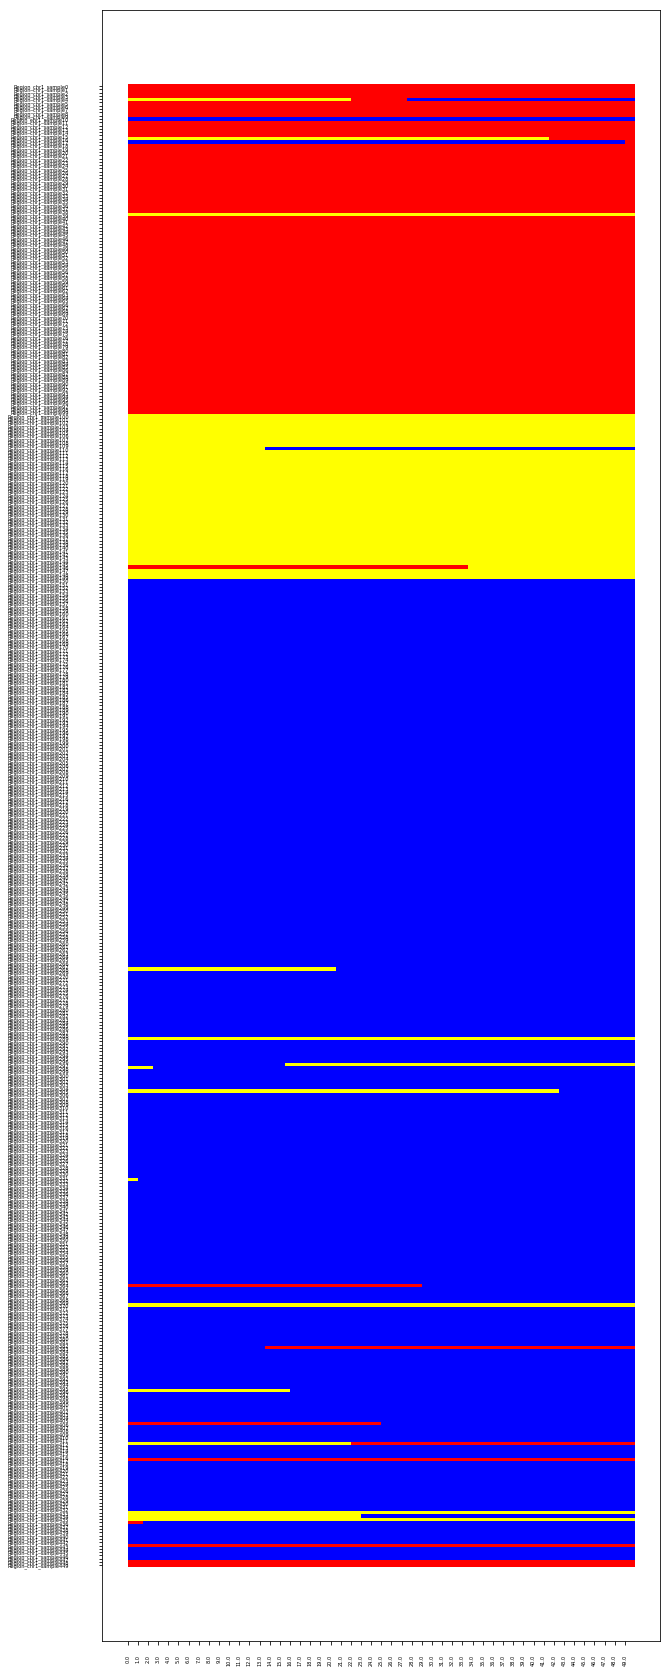

In [51]:
################
################        TRUTH

#### begin by compressing assignments by individuals. Lightens the load of the following plot.

from structure_tools.Ideogram_tools import compress_ideo, return_ideogram, chromosome_collections
import re

import re
chromosome_list= []
chromosomes= [Chr]

for hap in Whose:
    Subject = 'sample' + str(hap)
    chromosome_list.extend(['Region_chr'+str(Chr)+ '_' + Subject for Chr in chromosomes])

ideo = pd.DataFrame(Ideo,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

ideo = compress_ideo(ideo,chromosome_list,Out)

ID= 'truth'

fig= return_ideogram(ideo, chromosome_list,ID,height= 4, width= 7)